# Exercise for Principal component analysis (PCA)
A useful page
A Step-by-Step Explanation of Principal Component Analysis (PCA)
by Zakaria Jaadi
https://builtin.com/data-science/step-step-explanation-principal-component-analysis
Another useful page
PCA using Python (scikit-learn) by Michael Galarnyk
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la
import statistics
#Standardizes datasets to a unit scale (mean=0 and variance=1)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
source='./iris.data'
#Data information
#Read data
data= pd.read_csv(source,quotechar=",",names=\
                   ['Sepal length','Sepal width',\
                    'Petal length','Petal width','Species'],\
                   header=None)

In [10]:
class pca_mthd():   
    
    def __init__(self,features,indx,dat):
        self.features=features
        self.indx=indx
        self.dat=dat

    def algrtm(self,select_feature,targets):
        """
        By mathematical technique:
        1- Form m (sample) by n (feature) matrix X where 
        2- Center the data by x_i --> x_i-1/m \sum_i=1^m x_i 
        3- Form the n by n covariance matrix by C=X^T.X=sum_i=1^m x_i.x_i^T
        4- Diagonalize C = X^T.X = W Λ W^T, where W are the normalised eigenvectors,
           or PCA, and Λ is a diagonal matrix containing the eigenvalues.
           In general, pick the largest eigenvalues and the corresponding eigenvectors 
        """
        final = pd.DataFrame(columns=select_feature)
        #Step 1
        #separating features
        data=self.dat[select_feature]
        #Step 2
        data_cent=data-data.mean()
        #standardiazation
        std=self.std_dev(data,select_feature)
        data_stdz=data_cent/std
        #Step 3
        data_tpos=np.transpose(data_stdz) 
        cov_mat=np.dot(data_tpos,data_stdz)/(len(data)-1) 
        #Step 4
        eig_val,eig_vec=la.eig(cov_mat)           
        #sort eigenvalues from max value to min value 
        #and also corresponding eigenvectors 
        #NOTE:
        #eigenvalues are the same as variance value
        idx=eig_val.argsort()[::-1] 
        eig_val=eig_val[idx]
        eig_vec=eig_vec[:,idx]
        #Extra check of eigenvectors
        for i in range(len(select_feature)):
            if np.all(eig_vec[:,i]==-abs(eig_vec[:,i])):
                eig_vec[:,i]=-eig_vec[:,i]
            else:
                eig_vec[:,i]=eig_vec[:,i]
        #make principal components
        data_trsfm=np.dot(data_stdz,eig_vec) 
        finalDF=pd.DataFrame(data_trsfm,columns=select_feature)
        """
        Calculate variance and fractional variance of each feature 
        """       
        var_math,varfrac_math=self.var_alg(finalDF,select_feature)
        #print('Fractional variance of each feature by math calculation is:')
        #self.print_out(varfrac_math)
        
        return pd.concat([finalDF,self.dat[[self.indx]]], axis=1)

    
    def pyth_lib(self,nc,column):
        """
        PCA using python library sklearn
        """
        #separating species
        y=self.dat.loc[:,[self.indx]].values
        #separating features
        x=self.dat.loc[:,self.features].values
        #standardizing the features into unit scale
        x=StandardScaler().fit_transform(x)
        #x=self.dat[self.features]-self.dat[self.features].mean()  
        #selecting number of principal components
        pca=PCA(n_components=nc)
        #Fit in transform and get a 2 dimensional data
        principalComponent=pca.fit_transform(x)
        DF=pd.DataFrame(principalComponent, \
                                 columns=column)  
        finalDF=pd.concat([DF,self.dat[[self.indx]]],axis=1)
        #pca.components_ calculate eigenvectors
        explvar=pca.explained_variance_#np.insert(pca.explained_variance_,0,0)
        frac_var=np.round(pca.explained_variance_ratio_,decimals=3)#np.insert(pca.explained_variance_ratio_,0,0)
        cumlvar=np.cumsum(np.round(frac_var,decimals=3)) 
        DF_pc=pd.DataFrame(column,columns=['PCs'])  
        
        DF_var=pd.DataFrame(frac_var,columns=['Fractional variance'])
        DF_cumlvar=pd.DataFrame(cumlvar,columns=['Cumulative variance'])
        DF_var_cuml=pd.concat([DF_pc,DF_var,DF_cumlvar],axis=1)
        #calculates the linear combination of features
        #for each principal components
        loadings=np.round(pca.components_.T,decimals=3)
        DF_loadings=pd.DataFrame(loadings,columns=column,index=self.features)
        #print('Fractional variance of each feature by sklearn library is:')
        #self.print_out(frac_var)
        #Final data frame which includes species column along axis=1
        return finalDF,DF_var_cuml,DF_loadings
    
    def var_alg(self,data,column):
        target_data=data[column]
        """
        Unbiased sample variance is var=sum(x_i-x_mean_i)^2/(n-1)
        """
        var=np.sum((target_data-target_data.mean())**2)/(len(target_data))
        frac_var=var/np.sum(var)
        return var,frac_var
    
    def std_dev(self,data,column):
        var=self.var_alg(data,column)[0]
        return np.sqrt(var)
        
    
    def print_out(self,varble):
        for i in range(len(varble)):
            print('PC({0}): {1:1.3f}'.format(i+1,varble[i]))
        print('  ')
        
        
class plotgen():
    
    def figplot(self,ax,xlab,feat1,ylab,feat2,tit,targets,colors,dat,spec):
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_title(tit,fontsize=10)
        for spc,clr in zip(targets,colors):
            indicesToKeep=dat[spec]==spc
            ax.scatter(dat.loc[indicesToKeep,feat1],\
                       dat.loc[indicesToKeep,feat2],\
                       c=clr,s=50)
        ax.legend(targets,fontsize=15)
        ax.grid()    

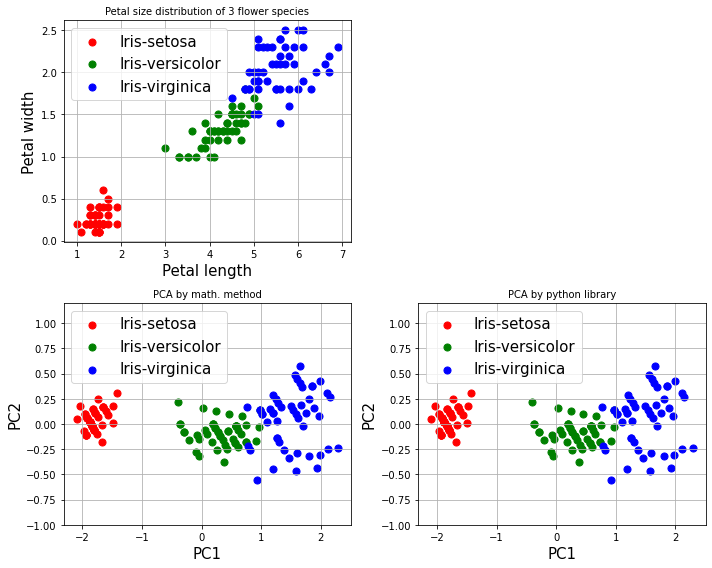

In [11]:
#Example how PCA works
#Just two features of 'petal length' and 'petal width' are selected
#The result is compared with PCA library of sklearn in python
#-----------------------------------------------------------------------
#Flower type
target=['Iris-setosa','Iris-versicolor','Iris-virginica']
#features of flower
features=['Petal length','Petal width']
#Two selected features in calculations
selected_features=['Petal length','Petal width']
#Title for column of flowers
indx_title='Species'
#Used in sklearn library functions
#number of components
n_comp=2
#Name of principal components whose number should be the same as n_comp
column=['PC1','PC2']
#For plot purposes
#For legend colour related to each 3 kind of flowers in data
colors=['r','g','b']
size_fig=(10,8)
nrow=2 
ncol=2
#-----------------------------------------------------------------------
mthd=pca_mthd(features,indx_title,data)
#PCA by mathematica methods
pca_alg=mthd.algrtm(selected_features,target)
#-----------------------------------------------------------------------
#PCA by python library
pca_lib,var_cuml,data_combns=mthd.pyth_lib(n_comp,column)
#-----------------------------------------------------------------------


#Plot figures
pl=plotgen()
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(figsize=size_fig,nrows=nrow, ncols=ncol)#, sharex=True, sharey=True)
pl.figplot(ax1,selected_features[0],\
           selected_features[0],\
           selected_features[1],\
           selected_features[1],\
           'Petal size distribution of 3 flower species',\
           target,colors,data,indx_title)

fig.delaxes(ax2)

pl.figplot(ax3,'PC1',\
           selected_features[0],\
           'PC2',\
           selected_features[1],\
           'PCA by math. method',\
           target,colors,pca_alg,indx_title)
ax3.set_ylim(-1.,1.2)

pl.figplot(ax4,column[0],\
           column[0],\
           column[1],\
           column[1],\
           'PCA by python library',\
           target,colors,pca_lib,indx_title)
ax4.set_ylim(-1.,1.2)

plt.tight_layout()
plt.show()


Combinations of data features against selected PCs:
------------------------------------------------
                PC1    PC2    PC3
Sepal length  0.522  0.372 -0.721
Sepal width  -0.263  0.926  0.242
Petal length  0.581  0.021  0.141
Petal width   0.566  0.065  0.634

Fractional and cumulative variance for each PCs:
------------------------------------------------
   PCs  Fractional variance  Cumulative variance
0  PC1                0.728                0.728
1  PC2                0.230                0.958
2  PC3                0.037                0.995



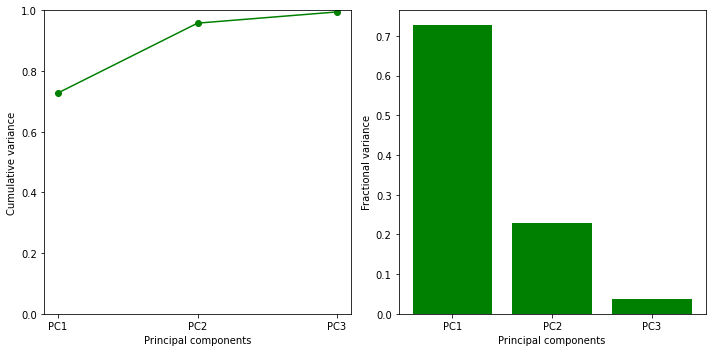

In [20]:
#Example of choosing different principal components by sklearn library

#Flower type
target=['Iris-setosa','Iris-versicolor','Iris-virginica']
#feature of flower
features=['Sepal length','Sepal width','Petal length','Petal width']
#Title for column of flowers
indx_title='Species'

#Used in sklearn library functions
#number of components
n_comp=3
#Name of principal components whose number should be the same as n_comp
column=['PC1','PC2','PC3']
#-----------------------------------------------------------------------
#PCA by python library
exmpl=pca_mthd(features,indx_title,data)
pca_lib,var_cuml,data_combns=exmpl.pyth_lib(n_comp,column)
print('')
print('Combinations of data features against selected PCs:')
print('------------------------------------------------')
print(data_combns)
print('')
print('Fractional and cumulative variance for each PCs:')
print('------------------------------------------------')
print(var_cuml)
print('')
#Plot figure
fig, (ax1, ax2) = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
ax1.plot(var_cuml['PCs'],var_cuml['Cumulative variance'],marker='o',
         color='g'
         )
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative variance')
ax1.set_ylim(0,1)

ax2.bar(var_cuml['PCs'],var_cuml['Fractional variance'],
        label=var_cuml['Fractional variance'],
        color='g'
       ) 

ax2.set_xlabel('Principal components')
ax2.set_ylabel('Fractional variance')
        
plt.tight_layout()
plt.show()